# Peer-graded Assignment: Анализ данных в задаче кредитного скоринга



In [1]:
! ls -l *credit_card*

-rw-rw-r-- 1 me me 2808134 Jan 31 15:46 _5e732cdeb15894a04f77e5fae011e572_credit_card_default_analysis.csv


In [2]:
import math
import statistics
from decimal import Decimal
from glob import glob

####! python3 -m pip install 'dython==0.7.0' 'numpy==1.22.0' 'pandas==1.3.5' 'scipy==1.7.3' 'seaborn==0.11.2' 'statsmodels==0.13.1'
import dython
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import statsmodels
from dython import nominal
from scipy import stats
from statsmodels.stats.proportion import proportion_confint

print(f"{dython.__version__=}")
print(f"{np.__version__=}")     
print(f"{pd.__version__=}")
print(f"{scipy.__version__=}")
print(f"{sns.__version__=}")
print(f"{statsmodels.__version__=}")

dython.__version__='0.7.0'
np.__version__='1.22.0'
pd.__version__='1.3.5'
scipy.__version__='1.7.3'
sns.__version__='0.11.2'
statsmodels.__version__='0.13.1'


In [3]:
df = pd.read_csv(glob('*credit_card_default_analysis.csv')[0])
df.sample(5, random_state=0)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
8225,8226,20000,1,1,2,33,1,2,2,2,...,18453,19755,19288,0,2260,0,1600,0,644,0
10794,10795,20000,2,2,2,35,0,0,2,0,...,19000,19000,20000,3400,0,1000,0,1000,0,0
9163,9164,230000,2,1,1,44,1,0,0,0,...,933,0,0,949,2873,933,0,0,0,0
26591,26592,100000,1,2,1,42,0,0,0,0,...,17758,18774,20272,5000,2000,2000,2000,2000,2000,0
6631,6632,150000,1,1,2,29,0,0,0,0,...,6469,5138,7810,6989,833,6488,5153,7833,7130,0


## Задание 1

> Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:   a)  о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки  b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

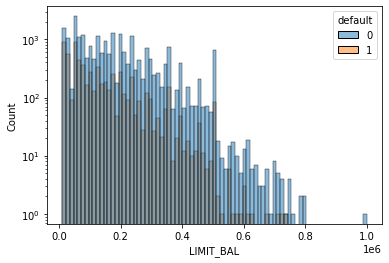

In [4]:
_ = sns.histplot(x='LIMIT_BAL', hue='default', data=df, log_scale=(False, True))

Гистограмма намекает на разницу: больше доля возврата—больше кредитный лимит

Попробуем проверить равенство медиан с помощью сравнения 95% доверительных интервалов для случаев вернул/не вернул, построенных с помощью bootstrap метода, как это было продемонстрировано на данном курсе:

In [5]:
from numpy.random import default_rng
rng = default_rng(0)

def get_bootstrap_samples(data, n_samples):
    indices = rng.integers(len(data), size=(n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha, method=None):
    kwargs = {}
    if method is not None:
        kwargs.update(method=method)
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)], **kwargs)
    return boundaries

- $H_0$ медианы равны (интервалы пересекаются, интервал для разницы медиан содержит ноль)
- $H_1$ медианы не равны (интервалы не пересекаются)

In [6]:
def print_bootstrap_ci95(X1, X2, n_samples=1000, alpha=0.05, prec=0, transformation = lambda x: x):
    x1_median_scores = list(map(np.median, map(transformation, get_bootstrap_samples(X1, n_samples))))
    x2_median_scores = list(map(np.median, map(transformation, get_bootstrap_samples(X2, n_samples))))
    delta_median_scores = [x2 - x1 for x1, x2 in zip(x1_median_scores, x2_median_scores)]

    print(f"{alpha=} (1-alpha) confidence interval for x1 median:",  stat_intervals(x1_median_scores, alpha))
    print(f"{alpha=} (1-alpha) confidence interval for x2 median:",  stat_intervals(x2_median_scores, alpha))        
    print(f"{1-alpha:.{prec}%} confidence interval for the difference between medians",  stat_intervals(delta_median_scores, alpha))

In [7]:
d0limit = df[df.default==0].LIMIT_BAL
d1limit = df[df.default==1].LIMIT_BAL
print_bootstrap_ci95(d1limit.values, d0limit.values)

alpha=0.05 (1-alpha) confidence interval for x1 median: [80000. 90000.]
alpha=0.05 (1-alpha) confidence interval for x2 median: [150000. 150000.]
95% confidence interval for the difference between medians [60000. 70000.]


$H_0$ отвергается на уровне значимости `0.05` в пользу $H_1$

Размер эффекта относительно большой четыре десятка процентов (60k абсолютный):

In [8]:
median_limit = np.median(df.LIMIT_BAL)
diff_median_limit = np.median(d0limit) - np.median(d1limit)
print(f"{median_limit=}, {diff_median_limit=}, {diff_median_limit/median_limit:.0%}")

median_limit=140000.0, diff_median_limit=60000.0, 43%


 Практическая значимость этого зависит от конкретной задачи.

По [условия применимости bootstrap](https://influentialpoints.com/Training/bootstrap_confidence_intervals-principles-properties-assumptions.htm):

- предполагаем, что данные не являются смещёнными, чтобы выборки с замещением породили бы несмещённую медиану
- $H_1$ здесь двухсторонняя, поэтому выборочное распределение медианы должно быть симметричным и гладким, что выполняется: выборочное распределение медианы для больших n является [приближённо нормальным](https://stats.stackexchange.com/questions/45124/central-limit-theorem-for-sample-medians/86804#86804) (для не дискретных величин, что выполняется для `LIMIT_BAL`)

### Проверка равенства распределений
- $H_0$ распределения одинаковые
- $H_1$ распределения разные

In [9]:
stats.mannwhitneyu(d0limit, d1limit)        

MannwhitneyuResult(statistic=95786286.5, pvalue=1.2255485818223303e-189)

$H_0$ отвергается на уровне значимости 0.05 в пользу $H_1$ (p-value ~1.2e-18)

Mann-Whitney U тест предполагает, что выборки вернул/не вернул (`d0limit`/`d1limit`) независимы.

## Задание 2
> Пол (SEX): Проверьте гипотезу о том,  что гендерный состав  группы людей вернувших и не вернувших кредит отличается.  Хорошо, если вы предоставите несколько различных решений  этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

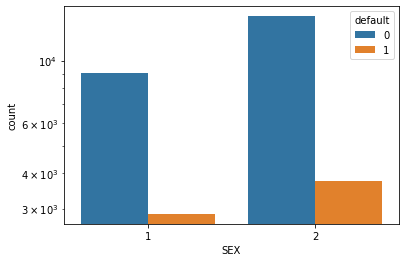

In [10]:
_ = sns.countplot(x='SEX', data=df, hue='default', log=True)

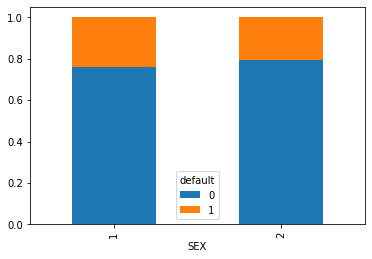

In [11]:
# normalized between 0 and 1:
_ = pd.crosstab(df.default, df.SEX).apply(lambda x: x/x.sum()).T.plot.bar(stacked=True)

График не указывает на большую разницу в долях возврата кредита в зависимости от пола. Проверим формально, используя Z-критерий для долей двух независимых выборок:

- $H_0: \mu_{p_1-p_2}=0$  не разницы в долях возврата между полами
- $H_1: \mu_{p_1-p_2}\ne 0$  разница есть

Здесь:

- $p_1$, $p_2$: доли возврата/не возврата для каждого пола
- $\mu$: среднее

Условия применимости:
- random
- independent
- normal `n*p` и `n*(1-p)` > 10

In [12]:
# note: proportions_* functions are adapted from the course practice

def proportions_confint_diff_ind_p(p1, p2, n1, n2, alpha=0.05):
    '''
    - p1, p2 sample proportions
    - n1, n2 sample sizes
    '''
    z = statistics.NormalDist().inv_cdf(1 - alpha / 2)   
    mu = p1 - p2
    sigma = (p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)**.5
    moe = z * sigma  # margin of error
    return (mu - moe, mu + moe)

def proportions_mu_moe_diff_ind_p(p1, p2, n1, n2, alpha=0.05):
    '''
    - p1, p2 sample proportions
    - n1, n2 sample sizes
    '''
    z = statistics.NormalDist().inv_cdf(1 - alpha / 2)   
    mu = p1 - p2
    sigma = (p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)**.5
    moe = z * sigma  # margin of error
    return mu, moe

def round_to_uncertainty(value, uncertainty):
    # https://stackoverflow.com/questions/53976847/report-uncertainty-given-a-mean-and-the-standard-error-show-only-significant-f
    # round the uncertainty to 1-2 significant digits
    u = Decimal(uncertainty).normalize()
    exponent = u.adjusted()  # find position of the most significant digit
    precision = u.as_tuple().digits[0] == 1  # is the first digit 1?
    u = u.scaleb(-exponent).quantize(Decimal(10) ** -precision)

    # round the value to remove excess digits
    return round(Decimal(value).scaleb(-exponent).quantize(u)), u, exponent

In [13]:
default=0
ns1 = (df.SEX==1).sum()  # note: see pd.crosstab below as an alternative
ns2 = (df.SEX==2).sum()
successes_s1 = ((df.default==default) & (df.SEX==1)).sum()
successes_s2 = ((df.default==default) & (df.SEX==2)).sum()
ps1 = successes_s1 / ns1
ps2 = successes_s2 / ns2
print(f"ps1={ps1:.4f} {successes_s1=} {ns1=}\nps2={ps2:.4f} {successes_s2=} {ns2=}")
diff, moe = proportions_mu_moe_diff_ind_p(ps2,ps1,ns2,ns1)
print("{} ± {} (×10**{})".format(*round_to_uncertainty(diff, moe)))

ps1=0.7583 successes_s1=9015 ns1=11888
ps2=0.7922 successes_s2=14349 ns2=18112
34 ± 10 (×10**-3)


95% доверительный интервал для разницы долей не содержит нуля, то есть $H_0$ отвергается в пользу $H_1$ на уровне значимости `0.05`

Найдём p-value: вероятность получить значение статистики такое же или ещё более экстремальное согласно $H_1$ при условии, что $H_0$ гипотеза верна:

In [14]:
mu = 0  # no difference according to H0
# same gender proportions for default/nondefault cases under H0
n = len(df)
assert (ns1+ns2) == n
phat0 = (df.default==default).sum() / n  # default/non-default proportion in the sample
assert math.isclose(df.default.value_counts(normalize=True)[default], phat0)
sigma = math.sqrt(2 * phat0 * (1 - phat0) / n)
zscore = (diff - mu)/sigma
round(zscore), 2*statistics.NormalDist().cdf(-abs(zscore))  # two-tails

(10, 0.0)

Z-score большой, p-value близко к нулю.

Нижняя граница для разницы долей: `0.024`. Являются ли 2% разницы в долях возврата между полами существенной на практике, может зависеть от задачи (вероятно нет в большинстве случаев).

Для сравнения можно найти ~95% доверительные интервалы, используя [`statsmodels`' `proportion_confint()`](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_confint.html):

In [15]:
for sex, nsuccesses, ntrials in [
    (1, successes_s1, ns1),
    (2, successes_s2, ns2)
]:
    for method in ['normal', 'wilson']:
        ci = proportion_confint(nsuccesses, ntrials, method=method)
        print(f"{method}: {sex=} [{ci[0]:.4f}, {ci[1]:.4f}], width={ci[1]-ci[0]:.3f}")

normal: sex=1 [0.7506, 0.7660], width=0.015
wilson: sex=1 [0.7505, 0.7659], width=0.015
normal: sex=2 [0.7863, 0.7981], width=0.012
wilson: sex=2 [0.7863, 0.7981], width=0.012


wilson, normal методы дают близкие результаты в этом случае.

Интервалы долей для разных полов не пересекаются, поэтому гипотеза о независимости доли возврата от пола отвергается в пользу гипотезы, что доля может зависеть от пола на уровне значимости `0.05`.

Можно ещё оценить силу зависимости между двоичными переменнами, используя [$\phi$ коэффициент (aka Matthews correlation coefficient (MCC)](https://en.wikipedia.org/wiki/Phi_coefficient)

In [16]:
def mcc(cont):
    n11, n10, n1t = cont.iloc[0]
    n01, n00, n0t = cont.iloc[1]
    nt1, nt0, _ = cont.iloc[2]
    return (n11*n00-n10*n01)/(n1t*n0t*nt0*nt1)**.5

round(mcc(pd.crosstab(df.default, df.SEX, margins=True)), 4)

-0.04

Для сравнения, корреляционный коэффициент, с помощью сторонней библиотеки:

In [17]:
sex_cols = ['default', 'SEX']
df_sex_corr = nominal.associations(df[sex_cols], nominal_columns=sex_cols, compute_only=True)
round(df_sex_corr['corr']['SEX']['default'], 4)

0.0395

Можно ещё посчитать $\phi$ через $\chi^2$:

In [18]:
cont_sex = pd.crosstab(df.default, df.SEX)
cont_sex

SEX,1,2
default,,
0,9015,14349
1,2873,3763


Выполняются условия для  𝜒2 :

много наблюдений (>40)
и количество ячеек <5 людей меньше 20% 

In [19]:
chi2, p, dof, expctd = stats.chi2_contingency(cont_sex)
print(f"{chi2=}, {p=}, {dof=}")
pd.DataFrame(expctd)

chi2=47.70879689062111, p=4.944678999412044e-12, dof=1


,0,1
0,9258.3744,14105.6256
1,2629.6256,4006.3744


In [20]:
n = cont_sex.sum().sum()
phi = (chi2/n)**.5
round(phi, 4)

0.0399

Значения корреляционных коэффициентов, посчитанных 3 способами близки к друг другу и указывают на слабую связь (p-value для $\chi^2$ ~5e-12 —то есть гипотеза независимости возрата кредита и пола также отвергается этим критерием)

## Задание 3
> Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг.  Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы  разность между наблюдаемым и ожидаемым количеством человек.  Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ?  Наличие какого образования является наилучшим индикатором того, что человек  отдаст долг ? наоборт, не отдаст долг ?

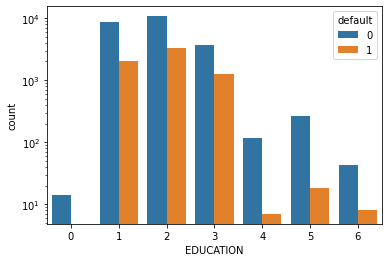

In [21]:
_ = sns.countplot(x='EDUCATION', hue='default', data=df, log=True)

График намекает, что в представленных данных для образования 1,2,3 (6?) больше доля невозврата. Вот тоже самое в нормализованном `[0, 1]` виде:

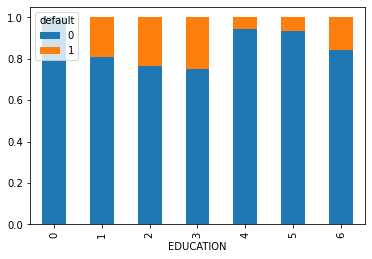

In [22]:
_ = pd.crosstab(df.default, df.EDUCATION).apply(lambda x: x/x.sum()).T.plot.bar(stacked=True)

In [23]:
cont_ed = pd.crosstab(df.default, df.EDUCATION, margins=True)
cont_ed

EDUCATION,0,1,2,3,4,5,6,All
default,,,,,,,,
0,14,8549,10700,3680,116,262,43,23364
1,0,2036,3330,1237,7,18,8,6636
All,14,10585,14030,4917,123,280,51,30000


In [24]:
cont_exp = stats.contingency.expected_freq(cont_ed)
pd.DataFrame(cont_exp)

,0,1,2,3,4,5,6,7
0,10.9032,8243.598,10926.564,3829.3596,95.7924,218.064,39.7188,23364.0
1,3.0968,2341.402,3103.436,1087.6404,27.2076,61.936,11.2812,6636.0
2,14.0000,10585.000,14030.000,4917.0000,123.0000,280.000,51.0000,30000.0


> составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. 

In [25]:
cont_ed_diff = cont_ed - cont_exp
# add totals, to get the feeling of the scale
cont_ed_diff.loc['All'] = cont_ed.loc['All']
cont_ed_diff['All'] = cont_ed['All']
cont_ed_diff

EDUCATION,0,1,2,3,4,5,6,All
default,,,,,,,,
0,3.0968,305.402,-226.564,-149.3596,20.2076,43.936,3.2812,23364
1,-3.0968,-305.402,226.564,149.3596,-20.2076,-43.936,-3.2812,6636
All,14.0000,10585.000,14030.000,4917.0000,123.0000,280.000,51.0000,30000


> Как бы вы предложили модифицировать таблицу так, чтобы привести   значения ячеек к одному масштабу не потеряв в интерпретируемости ?

In [26]:
def normalized_cont_table(cont):
    rel = cont.apply(lambda c: round(c/c['All'], 2)) 
    # row
    rel.loc['All'] = cont.loc['All'] # bottom margins shows abs counts
    # column
    rel['All'] = cont['All'] #  right margins shows abs counts
    return rel
normalized_cont_table(cont_ed_diff)        

EDUCATION,0,1,2,3,4,5,6,All
default,,,,,,,,
0,0.22,0.03,-0.02,-0.03,0.16,0.16,0.06,23364
1,-0.22,-0.03,0.02,0.03,-0.16,-0.16,-0.06,6636
All,14.00,10585.00,14030.00,4917.00,123.00,280.00,51.00,30000


 > Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборот, не отдаст долг ?
 
Согласно таблице:
- доктор, начальное образование и прочие категории (`0`, `4`, `5`) заметно более вероятно отдадут долг (*доктор* 22% более вероятно)
- магистра, бакалавр, выпускник школы и "нет данных" категории (`1`, `2`, `3`, `6`) имеют на глаз индикатор близкий к ожидаемому (*выпусник школы* на  3% менее вероятно вернёт)

Более формально наличие связи и её силу можно определить используя $\chi^2$ статистику и [Cramér's V меру $\phi_c$](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V):

Выполняются условия для  𝜒2 :

много наблюдений (>40)
и количество ячеек <5 людей меньше 20% 

- $H_0$: возврат/не возврат кредита и образование независимы
- $H_1$: $H_0$ ошибочна (есть зависимость)

In [27]:
chi2, p, dof, expctd = stats.chi2_contingency(cont_ed)
print(f"{chi2=}, {p=}, {dof=}")
pd.DataFrame(expctd)

chi2=163.2165578699707, p=1.5987086709565762e-27, dof=14


,0,1,2,3,4,5,6,7
0,10.9032,8243.598,10926.564,3829.3596,95.7924,218.064,39.7188,23364.0
1,3.0968,2341.402,3103.436,1087.6404,27.2076,61.936,11.2812,6636.0
2,14.0000,10585.000,14030.000,4917.0000,123.0000,280.000,51.0000,30000.0


$H_0$ отвергается в пользу $H_1$ на уровне значимости `0.05` (p-value ~1.6e-27), то есть присутствует ассоциация

In [28]:
ed_cols = ['default', 'EDUCATION']
df_ed_corr = nominal.associations(df[ed_cols], nominal_columns=ed_cols, nom_nom_assoc='cramer', compute_only=True)
df_ed_corr['corr']

,default,EDUCATION
default,1.000000,0.072393
EDUCATION,0.072393,1.000000


$\phi_c = 0.07$ -- корреляция есть, но слабая

## Задание 4
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

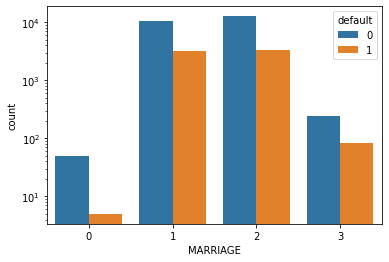

In [29]:
_ = sns.countplot(x='MARRIAGE', hue='default', data=df, log=True)

Отношения вернул/не вернул выглядят похоже для для случаев 1,2,3. Более наглядно это видно в нормализованном графике:

<AxesSubplot:xlabel='MARRIAGE'>

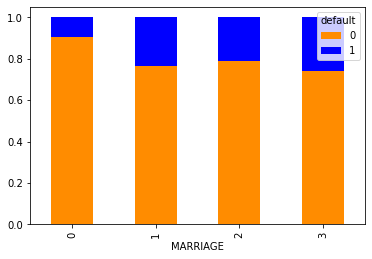

In [30]:
pd.crosstab(df.default, df.MARRIAGE).apply(lambda x: x/x.sum()).T.plot.bar(stacked=True, color=['DarkOrange','Blue'])

In [31]:
cont_mar = pd.crosstab(df.default, df.MARRIAGE)
pd.crosstab(df.default, df.MARRIAGE, margins=True)

MARRIAGE,0,1,2,3,All
default,,,,,
0,49,10453,12623,239,23364
1,5,3206,3341,84,6636
All,54,13659,15964,323,30000


Выполняются условия для $\chi^2$:
- много наблюдений (>40) 
- и количество ячеек <5 людей меньше 20% (ноль на показанных данных)

- $H_0$: вернул/не вернул кредит и семейное положения независимы
- $H_1$: $H_0$ ошибочна

In [32]:
chi2, p, dof, expctd = stats.chi2_contingency(cont_mar)
print(f"{chi2=}, {p=}, {dof=}")
pd.DataFrame(expctd)

chi2=35.66239583433609, p=8.825862457577375e-08, dof=3


,0,1,2,3
0,42.0552,10637.6292,12432.7632,251.5524
1,11.9448,3021.3708,3531.2368,71.4476


$H_0$ отвергается в пользу $H_1$ на уровне значимости `0.05` (p-value ~8e-8), то есть присутствует связь. Количественно связь можно оценить используя [Cramér's V меру $\phi_c$](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V):

In [33]:
 def crammerVcorr(chi2, n, cont):
     phi2 = chi2/n 
     r = len(cont)  # number of rows
     k = len(cont[0])
     assert all(len(row) == k for row in cont.iterrows())
     # wiki
     phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
     rcorr = r - ((r-1)**2)/(n-1)
     kcorr = k - ((k-1)**2)/(n-1)
     cramerVcorr = (phi2corr / min(kcorr-1, rcorr-1))**.5
     return cramerVcorr
    
round(crammerVcorr(chi2, len(df), cont_mar), 6)

0.033992

$\phi_c=0.03$ — слабая связь (близка к нулю)

Для сравнения, найдём корреляцию [`nominal.associations`](http://shakedzy.xyz/dython/modules/nominal/#associations):

In [34]:
mar_cols = ['default', 'MARRIAGE']
df_mar_corr = nominal.associations(df[mar_cols], nominal_columns=mar_cols, nom_nom_assoc='cramer', compute_only=True)
df_mar_corr['corr']

,default,MARRIAGE
default,1.000000,0.032997
MARRIAGE,0.032997,1.000000


Значения близки (~0.03), но не совпадают. Практически здесь нет разницы (связь слабая в любом случае).

## Задание 5
Возраст (AGE): Относительно двух групп людей  вернувших и не вернувших кредит  проверьте следующие гипотезы:   a)  о равенстве медианных значений возрастов людей   b) о равенстве распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

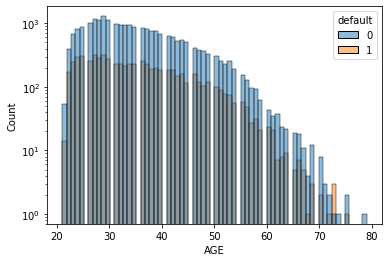

In [35]:
_ = sns.histplot(x='AGE', hue='default', data=df, log_scale=(False, True))

За исключением старшего возраста, вернул/не вернул отношения для разных возврастов выглядят похоже. Проверим это:
- $H_0$: 95% доверительные интервалы для медиан вернул/не вернул случаев пересекаются, а интервал для разницы медиан содержит ноль
- $H_1$: не пересекаются, а для разницы—не содержит ноль

In [36]:
d0age = df[df.default==0].AGE
d1age = df[df.default==1].AGE
print_bootstrap_ci95(d0age.values, d1age.values)

alpha=0.05 (1-alpha) confidence interval for x1 median: [34. 34.]
alpha=0.05 (1-alpha) confidence interval for x2 median: [34. 35.]
95% confidence interval for the difference between medians [0. 1.]


$H_0$ не может быть отвержена в пользу $H_1$ на уровне значимости `0.05`

In [37]:
median_age = np.median(df.AGE)
diff_median_age = np.median(d0age) - np.median(d1age)
print(f"{median_age=}, {diff_median_age=}, {diff_median_age/median_age:.0%}")

median_age=34.0, diff_median_age=0.0, 0%


Разница в пределах года (95% CI), практически ноль.

Условия применимости такие же как для задания №1 (много наблюдений, age непрерывная переменная).

### Проверка равенства распределений

- $𝐻_0$  распределения одинаковые
- $𝐻_1$  распределения разные


In [38]:
stats.mannwhitneyu(d0age, d1age)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.3725035434898616)

$H_0$ не отвергается в пользу $H_1$ на уровне значимости `0.05` (p-value: 0.3)

Условия применимости такие же как для задания №1